In [1]:
import os
os.getcwd()

'C:\\Users\\Prathamesh'

In [18]:
pip install -U scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [1]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
import os


In [2]:
file_path = "C:/Users/Prathamesh/Downloads/stock_market_dataset_Cleaned.xlsx"


In [3]:
df = pd.read_excel(file_path)

In [4]:
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (20000, 13)
        Date Company     Open    High      Low    Close   Volume      MA5  \
0 2015-01-02      LT   809.87  835.21  1833.92   468.77  1923142   688.62   
1 2015-01-05     HCL  1436.91  306.79  1889.85   397.14  4632512  1013.37   
2 2015-01-08   ICICI  1287.65  223.92  1335.77   107.21  4919639   890.48   
3 2015-01-14   WIPRO  1952.24  995.57  1641.29   475.63  2732907  1278.04   
4 2015-01-14    SBIN  1300.25  612.19   750.77  1259.86   896153   526.42   

      MA10    RSI  MACD  Volatility  Next_Day_Close  
0  1057.09   9.51  4.48        2.90         1991.33  
1  1742.53  60.28 -4.90        2.88         1639.25  
2   251.97  93.58 -9.06        3.52          124.15  
3   847.59  87.74  6.38        4.44          744.69  
4   873.06  15.17  3.75        2.70         1597.91  


In [7]:
date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
date_col = date_cols[0] if date_cols else df.columns[0]

In [8]:
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(by=date_col).reset_index(drop=True)


In [9]:
candidates = [c for c in df.columns if 'close' in c.lower()]
target_col = candidates[0] if candidates else df.select_dtypes(include=np.number).columns[0]

In [10]:
print(f"Date column: {date_col}")
print(f"Target column: {target_col}")

Date column: Date
Target column: Close


In [11]:
df_feat = df[[date_col, target_col]].rename(columns={date_col: 'Date', target_col: 'Close'})
df_feat['Close'] = df_feat['Close'].astype(float)

# Create lag features
lags = [1, 2, 3, 7, 14, 30]
for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['Close'].shift(lag)

# Moving averages
windows = [7, 14, 30]
for w in windows:
    df_feat[f'ma_{w}'] = df_feat['Close'].rolling(window=w, min_periods=1).mean()

# Daily returns
df_feat['return_1'] = df_feat['Close'].pct_change(1)
df_feat['return_7'] = df_feat['Close'].pct_change(7)

# Drop NA
df_feat.dropna(inplace=True)
print(df_feat.head())

         Date    Close    lag_1    lag_2    lag_3    lag_7   lag_14   lag_30  \
30 2015-02-09  1219.73  1565.15   417.57   943.62  1922.17  1007.85   468.77   
31 2015-02-09  1947.87  1219.73  1565.15   417.57  1755.82  1072.12   397.14   
32 2015-02-09  1977.86  1947.87  1219.73  1565.15  1741.85   249.87   107.21   
33 2015-02-10   296.81  1977.86  1947.87  1219.73  1216.72  1235.94   475.63   
34 2015-02-13  1483.46   296.81  1977.86  1947.87   943.62   785.61  1259.86   

           ma_7        ma_14        ma_30  return_1  return_7  
30  1265.780000  1203.719286  1031.024333 -0.220695 -0.365441  
31  1293.215714  1266.272857  1082.715333  0.596968  0.109379  
32  1326.931429  1389.700714  1145.070333  0.015396  0.135494  
33  1195.515714  1322.620000  1139.109667 -0.849934 -0.756057  
34  1272.635714  1372.466429  1146.563000  3.998012  0.572095  


In [12]:
n = len(df_feat)
test_size = int(np.ceil(0.2 * n))

train_df = df_feat.iloc[:-test_size]
test_df = df_feat.iloc[-test_size:]

X_train = train_df.drop(columns=['Date', 'Close'])
y_train = train_df['Close']
X_test = test_df.drop(columns=['Date', 'Close'])
y_test = test_df['Close']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Predictions
pred_lr = lr.predict(X_test_scaled)
pred_rf = rf.predict(X_test_scaled)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def metrics(y_true, y_pred):
    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    return rmse, mae

# ✅ Make sure you already have y_test, pred_lr, and pred_rf defined before running this
rmse_lr, mae_lr = metrics(y_test, pred_lr)
rmse_rf, mae_rf = metrics(y_test, pred_rf)

print("\nModel Performance:")
print(f"Linear Regression → RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}")
print(f"Random Forest     → RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")



Model Performance:
Linear Regression → RMSE: 383.55, MAE: 315.26
Random Forest     → RMSE: 18.88, MAE: 9.86


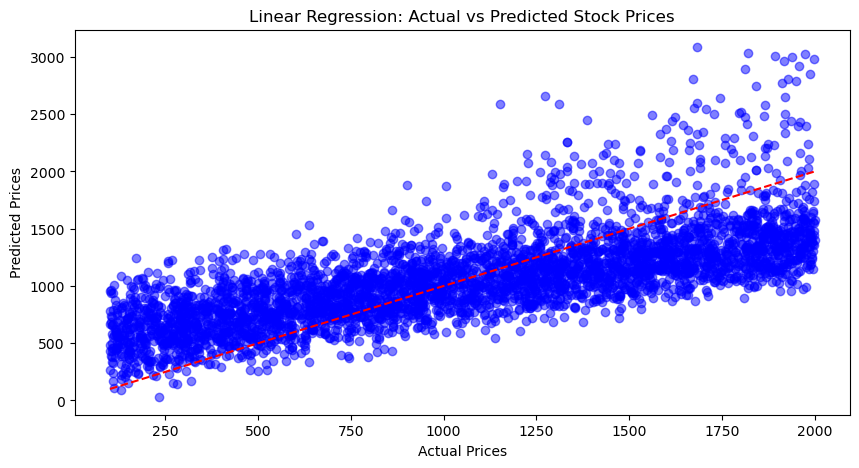

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, pred_lr, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Linear Regression: Actual vs Predicted Stock Prices")
plt.show()

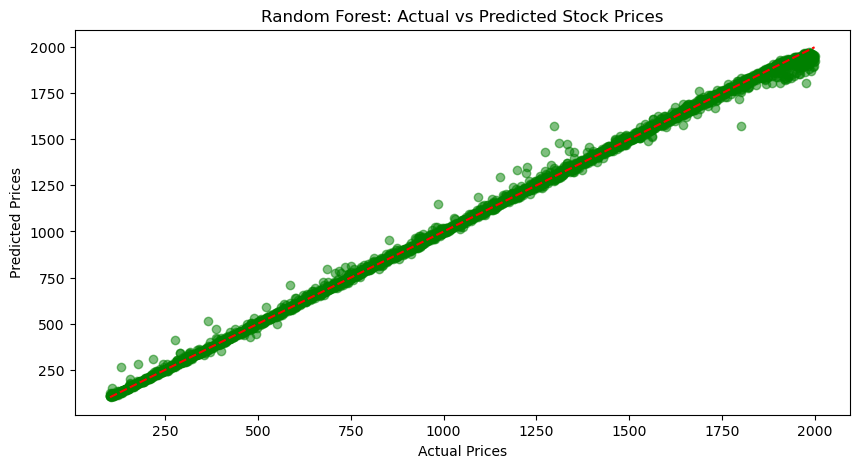

In [18]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, pred_rf, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Random Forest: Actual vs Predicted Stock Prices")
plt.show()


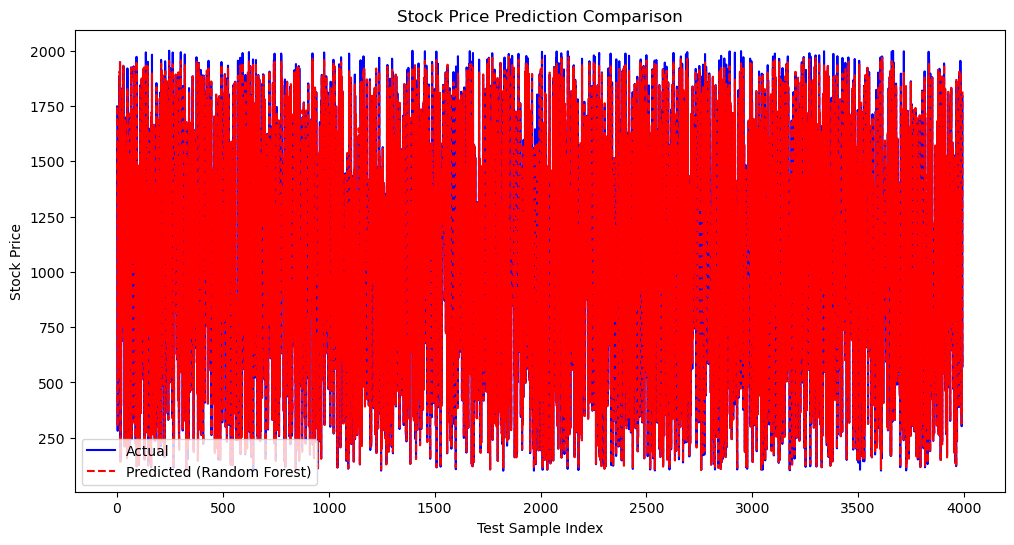

In [19]:
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test)), y_test, label="Actual", color='blue')
plt.plot(range(len(y_test)), pred_rf, label="Predicted (Random Forest)", color='red', linestyle='--')
plt.title("Stock Price Prediction Comparison")
plt.xlabel("Test Sample Index")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

os.makedirs('outputs', exist_ok=True)

# Save predictions
pred_df = test_df[['Date', 'Close']].copy()
pred_df['pred_rf'] = pred_rf
pred_df.to_csv('outputs/predictions.csv', index=False)

# Save model
with open('outputs/random_forest_model.pkl', 'wb') as f:
    pickle.dump({'model': rf, 'scaler': scaler, 'features': X_train.columns.tolist()}, f)

print("✅ Files saved:")
print("- outputs/predictions.csv")
print("- outputs/random_forest_model.pkl")

In [5]:
pip install yfinance


  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ------ --------------------------------- 0.5/3.0 MB 970.8 kB/s eta 0:00:03
     ----------------- ---------------------- 1.3/3.0 MB 1.8 MB/s eta 0:00:01
     ------------------------ --------------- 1.8/3.0 MB 2.1 MB/s eta 0:00:01
     -------------------------------------- - 2.9/3.0 MB 2.7 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 2.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproje